# Data Loading Tools
Ths notebook reflects the foundational step of the project process; it reads project datasets and produces data objects for modification and use in plate project steps. The cells in the notebook perform the following roles:

* Define libraries, drive data, and file paths
* Define data file paths
* Define function for property price paid data loading
* Define function for borough name data loading
* Define function for local council tax data loading
* Define function for UK indices of deprivation data loading
* Define function for Airbnb listings data loading
* Define function to create SQL database



# Define libraries, drive data, and file paths



In [ ]:
!pip install git+https://github.com/anhaidgroup/py_stringsimjoin.git

  Cloning https://github.com/anhaidgroup/py_stringsimjoin.git to /tmp/pip-req-build-srakbf9_
  Running command git clone --filter=blob:none --quiet https://github.com/anhaidgroup/py_stringsimjoin.git /tmp/pip-req-build-srakbf9_
  Resolved https://github.com/anhaidgroup/py_stringsimjoin.git to commit db0bb5b28a0a718140dd59311ca7c5537d7baca7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.8/643.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for py-stringsimjoin: filename=py_stringsimjoin-0.3.3-cp310-cp310-linux_x86_64.whl size=5285727 sha256=7c9910065ca33724f4db92ec4a32e5d8a12b843c5f9a53b1f5c34dad65b90f59
  Stored in directory: /tmp/pip-ephem-wheel-cache-rib2sfh1/wheels/7c/a8/2f/e7e1bec7a25608eaa4e6c3f53dc12b8ced959a76c21769912b
  Created wheel for py_stringmatching: filename=py_stringmatching-0.4.3-cp310-cp310-linux_x86_64.whl size=2361502 sha256=1d913709bff8b953a9108c7e912f60b9ef3480d51ac0c6f118fbdd045f179ab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
from collections import defaultdict
from dask import dataframe as dd
from google.colab import drive
import pandas as pd

In [ ]:
# define data filepaths to pass as args into loader functions, filepaths based on JR G-Drive
filepath_boroughs = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_borough/ldn_borough.csv"
filepath_counciltax = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_borough/ldn_counciltax2019.csv"
filepath_epdc  = "/content/drive/MyDrive/CIS5450/Term_Project/data/uk_property/uk_epdc_prop.csv"
filepath_indices = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_borough/ldn_id2019.csv"
filepath_listings = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_airbnb/listings_cond.csv"

# Function: Read Property Price Paid Data

*Description:* This cell comprises two parts: a function `read_epdc_prop_to_df` to read an attribute-linked property file and store the result as a dataframe, and a function `parse_epdc_prop_df` to parse the resulting dataframe.

*Data:* The reader function is designed to accept attribute-linked [property price data](https://reshare.ukdataservice.ac.uk/854942/) for England and Wales for the period 2011-2019. This dataset is a consolidation of two disparate datasets prepared by the UK Government: a [price paid dataset](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads) and an [environmental performance for buildings dataset](https://www.gov.uk/government/statistical-data-sets/live-tables-on-energy-performance-of-buildings-certificates). Use of the attribute-linked data allows for the generation of a property price per square metre valuation not possible with either individual dataset.

As a consolidation of two comprehensive datasets, the attribute-linked dataset contains a number of columns. Metadata for the most relevant columns is included below:

```
transactionid: An automatically-generated number at time of each published sale.
postcode: postal code used at time of original transaction.
price: Sale price stated on transfer deed.
dateoftransfer: Date when sale was completed, as stated on transfer deed.
propertytype: Letter code {D: detached, S: semi-detached, T: terraced, F: flat/maisonette, O: other}
oldnew: Indicate age of property {Y: A newly built property, N: an established build}
duration: Housing tenure {F: freehold, L: leasehold}
PAON/SAON: Primary and secondary addressable object name (i.e. address, unit).
tfarea: Total floor area of dwelling unit, in square metre (m^2).
```

**Note:** For more information on the data acquisition process, please refer to the [Project Code Archive](https://colab.research.google.com/drive/1Qog7FldvTOogSIrSKqsDEx8MRwefYr3J?usp=sharing).

*Return:* Function returns a Pandas dataframe of parsed attribute-linked property data.

In [ ]:
def read_epdc_prop_to_df(filepath):
    # use dask for multiprocessor csv reading support
    file_in = dd.read_csv(filepath, dtype="string")
    # return a pandas df using parsing helper method
    return parse_epdc_prop_df(file_in)

def parse_epdc_prop_df(df):
    # define cols to cast to int
    cols_int = ['id', 'price', 'year', 'numberrooms',
                'BUILDING_REFERENCE_NUMBER']
    # define cols to drop (mostly redundant, unneeded, or artefact)
    to_drop = ['Unnamed: 0', 'towncity', 'county', 'lad11nm', 'rgn11nm',
               'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL']
    # convert dask df to pandas df
    pd_df = df.compute()
    # drop specified cols from df
    pd_df.drop(axis=1, columns=to_drop, inplace=True)
    # for each col in df, attempt to convert to numeric value
    for col in pd_df.columns:
        # convert to numeric format generally
        pd_df[col] = pd.to_numeric(pd_df[col], errors='ignore')
        # if column targeted as integer
        if col in cols_int:
            # convert to int rather than float
            pd_df[col] = pd_df[col].astype(int)
    # convert district column to title case
    pd_df['district'] = pd_df['district'].str.title()
    # get (cost / floor area) ratio for each row and round to two dec points
    pd_df['cost_fl_area'] = round(pd_df['price']/pd_df['tfarea'], 2)
    return pd_df

# Function: Read Borough Names

*Description:* This cell contains a function `read_boroughs_to_list`, which given a csv of London boroughs and their location in the Greater London (inner, outer), will return relevant inner London boroughs as a list.

*Data:* The function is designed to accept a two-column .csv of London borough names and location (innerm, outer) in Greater London. Borough names were derived from [borough council tax data](https://data.london.gov.uk/dataset/council-tax-charges-bands-borough), while geographic location was informed by definition in the London Government Act 1963 as described by [Wikipedia](https://en.wikipedia.org/wiki/Inner_London). Note that while City of London and Newham are not officially recognized as boroughs of Inner London, for common statistical purposes, we include both.

*Return:* Function returns a list of Inner London boroughs:


```
boroughs = ['Camden', 'City of London', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea',
'Lambeth', 'Lewisham', 'Newham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'City of Westminster']
```



In [ ]:
def read_boroughs_to_list(filepath):
    # read file
    file_in = pd.read_csv(filepath, dtype={"neighbourhood": "str"})
    # filter by inner boroughs
    file_in = file_in[file_in['location'] == 'inner']
    # return boroughs as list
    return file_in['neighbourhood'].values.tolist()

# Function: Read Local Council Tax Data

*Description:* This cell contains a function `read_council_tax_to_df`, which given a .csv of historical council tax data for each borough in London, will return the data as a Pandas dataframe.

*Data:* The function is designed to accept a multi-sheet .csv of London [borough council tax data](https://data.london.gov.uk/dataset/council-tax-charges-bands-borough). This data is intended as a supplement to provide insight into any prospective variability within the relationship between housing purchase prices and STR frequency in inner London.

*Return:* Function returns London borough council tax data (including bands) as Pandas dataframe.

In [ ]:
def read_council_tax_to_df(filepath):
    # initialize dictionary for col types
    d_tax = defaultdict(lambda x: "int32")
    d_tax['code'], d_tax['borough'] = "string", "string"
    # read file
    file_in = pd.read_csv(filepath)
    return file_in

# Function: Read UK Indices of Deprivation Data

*Description:* This cell contains a function `read_indices_to_df`, which given a .csv of United Kingdom Indices of Deprivation (2019) for each borough in London, will return the data as a Pandas dataframe.

*Data:* The function is designed to accept a .csv of [summary indices of deprivation](https://data.london.gov.uk/dataset/indices-of-deprivation) for each borough in London, including indices for income, education, employment, health deprivation and disability, crime, barriers to housing and services, and living environment quality.

The UK Indices of Deprivation (2019) are a set of indicators generated by the UK Ministry of Housing, Communities, and Local Government to provide a relative measure of deprivation for small areas across England. These small areas (Lower-layer Super Output Areas) are aggregated to the borough level for purposes of this study.

As with the tax data, this data is intended as a supplement to provide insight into any prospective variability within the relationship between housing purchase prices and STR frequency in inner London.

*Return:* Function returns UK indices of deprivation for London boroughs as Pandas dataframe.

In [ ]:
def read_indices_to_df(filepath):
    # initialize dictionary for col types
    d_tax = defaultdict(float)
    d_tax['code'], d_tax['borough'] = "string", "string"
    # read file
    file_in = pd.read_csv(filepath)
    # generate prefixes and suffixes of columns to keep
    prefix = ['income','hdep', 'crime', 'housebar', 'env']
    suffix = ['-avgrank', '-rankavgrank', '-avgscore', '-rankavgscore']
    # generate list of columns to keep and return subset of data
    to_keep = ['borough']
    for pfx in prefix:
      for sfx in suffix:
        to_keep.append(pfx + sfx)
    return file_in[to_keep]

# Function: Read Airbnb Listing Data

*Description:* This cell comprises two parts: a function `read_listings_to_df` to read a .csv and store the result as a dataframe, and a function `parse_listings_df` to perform basic data cleanup and encoding as loading proceeds.

*Data:* The reader function is designed to accept condensed Airbnb listing data for Greater London for the period ending in 2020. This dataset is prepared by advocacy group [Inside Airbnb,](http://insideairbnb.com/about/) and is drawn from their data archive.

Metadata for the most relevant columns is included below:

```
id: Unique identifier of STR property
name: Name of STR property as it appears on the platform
hostid, hostname: Unique identifier of host and their associated name
neighbourhood: STR location within borough
price: Dollar price per evening
minimum_nights: Minimum number of nights required to book STR
```

*Return:* Function returns Pandas dataframe of parsed STR listings for Greater London for a period ending in 2020.

In [ ]:
def read_listings_to_df(filepath):
    # assign dtypes to each column
    d_listing = {
        "id": "int32",
        "name": "string",
        "host_id": "int32",
        "host_name": "string",
        "neighbourhood_group": "string",
        "neighbourhood": "string",
        "latitude": "float",
        "longitude": "float",
        "room_type": "string",
        "price": "float",
        "minimum_nights": "int32",
        "number_of_reviews": "int32",
        "last_review": "string",
        "reviews_per_month": "float",
        "calculated_host_listings_count": "int32",
        "availability_365": "int32",
    }
    # read csv using dtype dict
    file_in = pd.read_csv(filepath, dtype=d_listing)
    return parse_listings_df(file_in)


def parse_listings_df(dataframe):
    # rename column for common alignment
    dataframe.rename(inplace=True, columns={'neighbourhood': 'borough'})
    # convert last_review as date/time
    dataframe['last_review'] = pd.to_datetime(dataframe['last_review'],format='%Y-%m-%d')
    # build array of columns to drop
    to_drop = ['name', 'host_name', 'neighbourhood_group']
    # drop specified columns from listings
    dataframe.drop(axis=1, columns=to_drop, inplace=True)
    return dataframe

# Load Data in Main

In [ ]:
boroughs = read_boroughs_to_list(filepath_boroughs)
indices = read_indices_to_df(filepath_indices)
listings = read_listings_to_df(filepath_listings)
tax_rates = read_council_tax_to_df(filepath_counciltax)
properties = read_epdc_prop_to_df(filepath_epdc)

# Dataset Cleaning

## Property Price Paid Data Cleaning and Initial Exploration

In this section we will:


*   Explore the data inside the property price paid dataset







In [ ]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57718 entries, 0 to 57717
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             57718 non-null  int64  
 1   transactionid                  57718 non-null  object 
 2   oa11                           57718 non-null  object 
 3   postcode                       57718 non-null  object 
 4   price                          57718 non-null  int64  
 5   dateoftransfer                 57718 non-null  object 
 6   propertytype                   57718 non-null  object 
 7   oldnew                         57718 non-null  object 
 8   duration                       57718 non-null  object 
 9   paon                           57718 non-null  object 
 10  saon                           23424 non-null  object 
 11  street                         57715 non-null  object 
 12  locality                       3163 non-null 

Since we are interested in exploring the relationship between STR frequency and housing purchase costs by borough, we will eliminate some of the columns that won't be relevant to our analysis.






In [ ]:
properties_df = properties[['price',
                            'dateoftransfer',
                            'propertytype',
                            'oldnew',
                            'district',
                            'cost_fl_area']]

properties_df.head(5)

,price,dateoftransfer,propertytype,oldnew,district,cost_fl_area
0,445000,2018-10-01,F,N,Wandsworth,9468.09
1,580000,2018-10-17,F,N,Wandsworth,8055.56
2,121250,2018-07-03,F,N,Wandsworth,2694.44
3,128000,2019-08-27,F,N,Wandsworth,2666.67
4,1250000,2019-04-30,F,N,Wandsworth,13888.89


In [ ]:
# How many rows are there in this dataset?
len(properties_df.index)

57718

In [ ]:
# Do we have any null rows?
properties_df.isna().sum()

price             0
dateoftransfer    0
propertytype      0
oldnew            0
district          0
cost_fl_area      0
dtype: int64

In [ ]:
# Let's check the datatypes for these columns
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57718 entries, 0 to 57717
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           57718 non-null  int64  
 1   dateoftransfer  57718 non-null  object 
 2   propertytype    57718 non-null  object 
 3   oldnew          57718 non-null  object 
 4   district        57718 non-null  object 
 5   cost_fl_area    57718 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.6+ MB


In [ ]:
def cast_helper(df, cols_arr, data_type):
    # for each col in df, attempt to convert to numeric value
    for col in cols_arr:
        # convert to numeric format generally
       df[col] = df[col].astype(data_type)
    return df

In [ ]:
# Let's update the datatypes in the non-numeric columns
from datetime import datetime

cols_to_update = ['propertytype', 'oldnew', 'district']
properties_df = cast_helper(properties_df, cols_to_update, 'string')
properties_df['dateoftransfer'] = pd.to_datetime(properties_df['dateoftransfer'])
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57718 entries, 0 to 57717
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   price           57718 non-null  int64         
 1   dateoftransfer  57718 non-null  datetime64[ns]
 2   propertytype    57718 non-null  string        
 3   oldnew          57718 non-null  string        
 4   district        57718 non-null  string        
 5   cost_fl_area    57718 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), string(3)
memory usage: 2.6 MB


<ipython-input-16-3abf18dd6474>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(data_type)
<ipython-input-17-78fdcd1d8d01>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df['dateoftransfer'] = pd.to_datetime(properties_df['dateoftransfer'])


### Visualize Correlation among features

 We are going to visualize the data using a correlation matrix plot heatmap to see if any variables seem to be strongly correlated with price. This will help us eliminate unecessary features.

<ipython-input-18-15b9727c39b2>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(properties_df.corr(), cmap='coolwarm')


<Axes: >

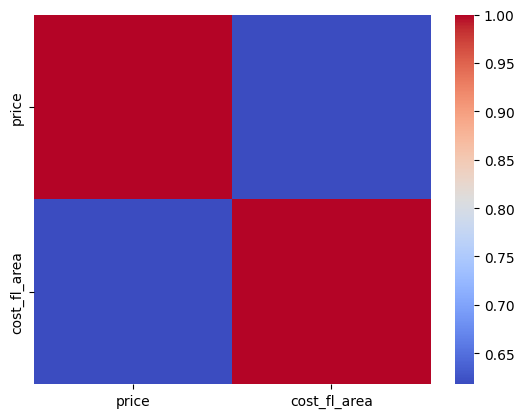

In [ ]:
import seaborn as sns
%matplotlib inline

sns.heatmap(properties_df.corr(), cmap='coolwarm')

###Viewing Data By District
We are going to see the data distribution by district.



In [ ]:
property_avg_by_district = properties_df.groupby('district').mean().reset_index()
property_avg_by_district = property_avg_by_district.sort_values(by=['cost_fl_area'], ascending=False).reset_index(drop=True)
property_avg_by_district

<ipython-input-19-58985f5ac663>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  property_avg_by_district = properties_df.groupby('district').mean().reset_index()


,district,price,cost_fl_area
0,Kensington And Chelsea,2.100748e+06,16135.826273
1,City Of Westminster,1.401428e+06,13431.389554
2,City Of London,8.333125e+05,12990.393577
3,Camden,1.138965e+06,10919.350311
4,Hammersmith And Fulham,9.847065e+05,9601.691831
5,Islington,7.621404e+05,8970.427173
6,Wandsworth,7.755212e+05,8091.661552
7,Hackney,6.495731e+05,7872.211092
8,Southwark,6.142248e+05,7551.588104
9,Lambeth,6.223003e+05,7404.709092


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# fig = plt.figure(figsize =(25, 10))
# plt.bar(property_avg_by_district['district'], property_avg_by_district['tfarea'])
# plt.xticks(fontsize=16, rotation=90)
# plt.yticks(fontsize=22)
# plt.ylabel('Cost per squared meter in US$ dollars', fontsize=25)
# plt.xlabel('District', fontsize=25)
# plt.title('Price per squared meter', fontsize=30)
# plt.show()



## Listings Data Cleaning and Initial Exploration

In [ ]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86358 entries, 0 to 86357
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              86358 non-null  int32         
 1   host_id                         86358 non-null  int32         
 2   borough                         86358 non-null  string        
 3   latitude                        86358 non-null  float64       
 4   longitude                       86358 non-null  float64       
 5   room_type                       86358 non-null  string        
 6   price                           86358 non-null  float64       
 7   minimum_nights                  86358 non-null  int32         
 8   number_of_reviews               86358 non-null  int32         
 9   last_review                     64842 non-null  datetime64[ns]
 10  reviews_per_month               64842 non-null  float64       
 11  ca

In [ ]:
listings_df = listings[['borough',
                        'room_type',
                        'price',
                        'minimum_nights',
                        'number_of_reviews',
                        'last_review',
                        'reviews_per_month']]
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86358 entries, 0 to 86357
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   borough            86358 non-null  string        
 1   room_type          86358 non-null  string        
 2   price              86358 non-null  float64       
 3   minimum_nights     86358 non-null  int32         
 4   number_of_reviews  86358 non-null  int32         
 5   last_review        64842 non-null  datetime64[ns]
 6   reviews_per_month  64842 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), string(2)
memory usage: 4.0 MB


### Visualize Correlation among features

 We are going to visualize the data using a correlation matrix plot heatmap to see if any variables seem to be strongly correlated with price. This will help us eliminate unecessary features.

<ipython-input-23-5d7ebaaee9a8>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(listings_df.corr(), cmap='coolwarm')


<Axes: >

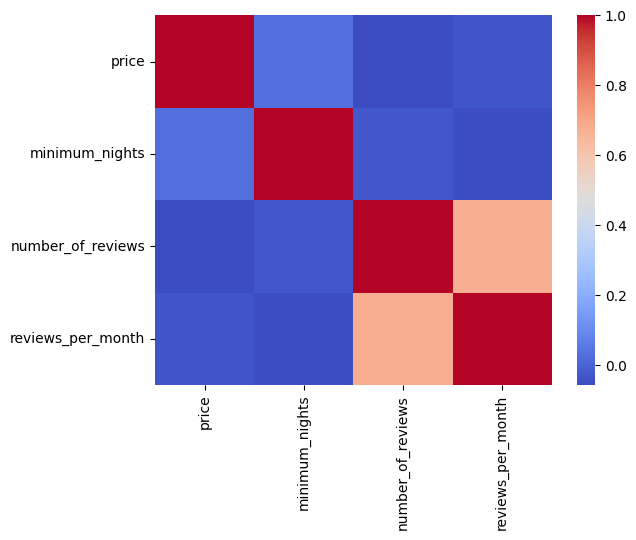

In [ ]:
%matplotlib inline

sns.heatmap(listings_df.corr(), cmap='coolwarm')

In [ ]:
print(listings_df['borough'].unique())
print(listings_df['room_type'].unique())

<StringArray>
[             'Islington', 'Kensington and Chelsea',            'Westminster',
 'Hammersmith and Fulham',             'Wandsworth',                 'Barnet',
               'Hounslow',   'Richmond upon Thames',               'Haringey',
                'Hackney',              'Southwark',                'Croydon',
          'Tower Hamlets',         'Waltham Forest',                  'Brent',
                 'Camden',                 'Newham',                'Lambeth',
              'Redbridge',                 'Merton',               'Lewisham',
                'Bromley',               'Havering',              'Greenwich',
                 'Ealing',                'Enfield',         'City of London',
   'Barking and Dagenham',             'Hillingdon',                 'Harrow',
   'Kingston upon Thames',                 'Bexley',                 'Sutton']
Length: 33, dtype: string
<StringArray>
['Private room', 'Entire home/apt', 'Hotel room', 'Shared room']
Length: 4, d

In [ ]:
# Limit our airbnb data to include only the 13 burroughs:
#  Camden, Greenwich, Hackney, Hammersmith and Fulham,
# Islington, Kensington and Chelsea, Lambeth, Lewisham, Newham,
# Southwark, Tower Hamlets, Wandsworth, Westminster, and the City of London

burroughs = ['Camden',
             'Greenwich',
             'Hackney',
             'Hammersmith and Fulham',
             'Islington',
             'Kensington and Chelsea',
             'Lambeth',
             'Lewisham',
             'Newham',
             'Southwark',
             'Tower Hamlets',
             'Wandsworth',
             'Westminster',
             'City of London']
cleaned_listings_df = listings_df.loc[listings_df['borough'].isin(burroughs)].reset_index(drop=True)

# how many null rows do we have?
cleaned_listings_df.isna().sum()


borough                  0
room_type                0
price                    0
minimum_nights           0
number_of_reviews        0
last_review          16085
reviews_per_month    16085
dtype: int64

In [ ]:
# fill the 16085 nulls with 0
cleaned_listings_df['reviews_per_month'] = cleaned_listings_df['reviews_per_month'].fillna(0)
cleaned_listings_df.isna().sum()

borough                  0
room_type                0
price                    0
minimum_nights           0
number_of_reviews        0
last_review          16085
reviews_per_month        0
dtype: int64

###Viewing Data By District
We are going to see the data distribution by district.


In [ ]:
airbnb_by_district = cleaned_listings_df.groupby('borough').size().reset_index().rename(columns={0: "num_listings"})
airbnb_by_district = airbnb_by_district.sort_values(by=['num_listings'], ascending=False).reset_index(drop=True)
airbnb_by_district

,borough,num_listings
0,Westminster,9943
1,Tower Hamlets,8321
2,Camden,6243
3,Hackney,6210
4,Kensington and Chelsea,6079
5,Islington,5019
6,Southwark,4957
7,Lambeth,4881
8,Wandsworth,4261
9,Hammersmith and Fulham,4233


## View side by side discrepancies in districts and boroughs

In [ ]:
# property_avg_by_district and airbnb_by_district
display(property_avg_by_district[['district']].sort_values(by='district'))
display(airbnb_by_district[['borough']].sort_values(by='borough'))

,district
3,Camden
2,City Of London
1,City Of Westminster
12,Greenwich
7,Hackney
4,Hammersmith And Fulham
5,Islington
0,Kensington And Chelsea
9,Lambeth
11,Lewisham


,borough
2,Camden
13,City of London
12,Greenwich
3,Hackney
9,Hammersmith and Fulham
5,Islington
4,Kensington and Chelsea
7,Lambeth
10,Lewisham
11,Newham


We can see from the extract of distrits and boroughs that we need to:


*   Clean up names so that they match exactly.


> The property dataset capitalizes 'Of' and 'And', the airbnb doesn't.



> The property dataset uses 'City of Westminster' and airbnb uses 'Westminster, so we will replace City of Westminster with the latter.




In [ ]:
# Change names in the smaller dataset, property_avg_by_district
# City Of London to City of London
# Hammersmith And Fulham to Hammersmith and Fulham
# Kensington And Chelsea to Kensington and Chelsea


property_avg_by_district.loc[property_avg_by_district.district =='City Of London', 'district'] = 'City of London'
property_avg_by_district.loc[property_avg_by_district.district =='Hammersmith And Fulham', 'district'] = 'Hammersmith and Fulham'
property_avg_by_district.loc[property_avg_by_district.district =='Kensington And Chelsea', 'district'] = 'Kensington and Chelsea'
property_avg_by_district.loc[property_avg_by_district.district =='City Of Westminster', 'district'] = 'Westminster'

property_avg_by_district

,district,price,cost_fl_area
0,Kensington and Chelsea,2.100748e+06,16135.826273
1,Westminster,1.401428e+06,13431.389554
2,City of London,8.333125e+05,12990.393577
3,Camden,1.138965e+06,10919.350311
4,Hammersmith and Fulham,9.847065e+05,9601.691831
5,Islington,7.621404e+05,8970.427173
6,Wandsworth,7.755212e+05,8091.661552
7,Hackney,6.495731e+05,7872.211092
8,Southwark,6.142248e+05,7551.588104
9,Lambeth,6.223003e+05,7404.709092


In [ ]:
# how many rows in our airbnb before dropping westminster?
len(cleaned_listings_df.index)

66771

#Validating borough and district names

Join on count of airbnb listings.

In [ ]:
merged_df = cleaned_listings_df.merge(airbnb_by_district, left_on=['borough'], right_on=['borough'],
                      how='left', indicator=True)

merged_df.head(10)

,borough,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,num_listings,_merge
0,Islington,Private room,65.0,1,21,2020-02-22,0.18,5019,both
1,Kensington and Chelsea,Entire home/apt,100.0,10,89,2020-03-16,0.71,6079,both
2,Westminster,Entire home/apt,300.0,3,42,2019-11-02,0.38,9943,both
3,Hammersmith and Fulham,Private room,150.0,3,0,NaT,0.00,4233,both
4,Wandsworth,Entire home/apt,65.0,21,35,2020-03-30,0.70,4261,both
5,Hackney,Entire home/apt,80.0,6,52,2019-03-30,0.44,6210,both
6,Southwark,Private room,70.0,2,55,2019-06-27,0.46,4957,both
7,Tower Hamlets,Entire home/apt,65.0,2,137,2017-04-21,1.18,8321,both
8,Hammersmith and Fulham,Private room,62.0,2,366,2020-03-15,3.18,4233,both
9,Hammersmith and Fulham,Entire home/apt,296.0,5,35,2020-02-28,0.37,4233,both


In [ ]:
# change column names so that it is easier to interpret after merge
merged_df.rename(columns = {'price':'airbnb_price'}, inplace = True)
merged_df = merged_df.drop(['_merge'], axis=1)
merged_df.head(3)

,borough,room_type,airbnb_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,num_listings
0,Islington,Private room,65.0,1,21,2020-02-22,0.18,5019
1,Kensington and Chelsea,Entire home/apt,100.0,10,89,2020-03-16,0.71,6079
2,Westminster,Entire home/apt,300.0,3,42,2019-11-02,0.38,9943


In [ ]:
# %matplotlib inline

# fig = plt.figure(figsize =(25, 10))
# plt.bar(airbnb_by_district['borough'], airbnb_by_district['num_listings'])
# plt.xticks(fontsize=16, rotation=90)
# plt.yticks(fontsize=22)
# plt.ylabel('Number of Listings', fontsize=25)
# plt.xlabel('District', fontsize=25)
# plt.title('Number of Airbnb listings per District', fontsize=30)
# plt.show()

# Indices of Deprivation data cleaning and initial exploration

In this section we will:


*   Explore the Indices of deprivation 2019 dataset. We think this data provides relevant socioeconomic context for each boroughs and may thus make our models less biase. We aim to capture the nuanced relationships between socioeconomic factors and housing market dynamics in our models.


In [ ]:
indices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   borough                33 non-null     object 
 1   income-avgrank         33 non-null     float64
 2   income-rankavgrank     33 non-null     int64  
 3   income-avgscore        33 non-null     float64
 4   income-rankavgscore    33 non-null     int64  
 5   hdep-avgrank           33 non-null     float64
 6   hdep-rankavgrank       33 non-null     int64  
 7   hdep-avgscore          33 non-null     float64
 8   hdep-rankavgscore      33 non-null     int64  
 9   crime-avgrank          33 non-null     float64
 10  crime-rankavgrank      33 non-null     int64  
 11  crime-avgscore         33 non-null     float64
 12  crime-rankavgscore     33 non-null     int64  
 13  housebar-avgrank       33 non-null     float64
 14  housebar-rankavgrank   33 non-null     int64  
 15  housebar

Let's narrow down our focus to columns containing the rank for each measure because it provides a relative ordering of local authority districts based on deprivation measures. In this dataset, a rank of 1 indicates the highest level of deprivation for a specific measure, while a rank of 317 represents the least deprived. It's noteworthy that there are 317 local authority districts in England. (source: https://data.london.gov.uk/dataset/indices-of-deprivation)

In [ ]:
# Selecting relevant columns
indices_rank  = indices[['borough', 'income-rankavgrank', 'income-rankavgscore','hdep-rankavgrank','hdep-rankavgscore','crime-rankavgrank','crime-rankavgscore','housebar-rankavgrank','housebar-rankavgscore','env-rankavgrank','env-rankavgscore']]

# Renaming hdep to be more desriptive
indices_rank = indices_rank.rename(columns={'hdep-rankavgrank': 'health-rankavgrank', 'hdep-rankavgscore':'health-rankavgscore'})
indices_rank = indices_rank.astype({'borough': 'string'})


The selected columns contain indicators across the following domains of deprivation:



*   **Income Deprivation:** *income-rankavgrank, income-rankavgscore*
*   **Health Deprivation and Disability:** *health-rankavgrank, health-rankavgscore*
*   **Crime:** *crime-rankavgrank, crime-rankavgscore*
*   **Barriers to Housing and Services:** *housebar-rankavgrank,  housebar-rankavgscore*
* **Living Environment Deprivation:** *env-rankavgrank, env-rankavgscore*

In [ ]:
indices_rank.describe()

,income-rankavgrank,income-rankavgscore,health-rankavgrank,health-rankavgscore,crime-rankavgrank,crime-rankavgscore,housebar-rankavgrank,housebar-rankavgscore,env-rankavgrank,env-rankavgscore
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,105.212121,114.484848,192.030303,196.787879,86.424242,88.727273,40.242424,46.121212,50.030303,63.272727
std,82.474525,73.390276,70.055105,71.336683,66.381488,63.905826,52.405886,58.125273,44.330072,50.124391
min,4.000000,19.000000,67.000000,75.000000,9.000000,11.000000,1.000000,1.000000,2.000000,3.000000
25%,38.000000,54.000000,136.000000,135.000000,37.000000,45.000000,10.000000,10.000000,16.000000,25.000000
50%,87.000000,97.000000,194.000000,196.000000,71.000000,71.000000,19.000000,21.000000,36.000000,48.000000
75%,162.000000,162.000000,238.000000,254.000000,111.000000,113.000000,39.000000,47.000000,71.000000,90.000000
max,292.000000,283.000000,310.000000,311.000000,317.000000,317.000000,242.000000,242.000000,166.000000,190.000000


### Visualizing the spread of the dataset

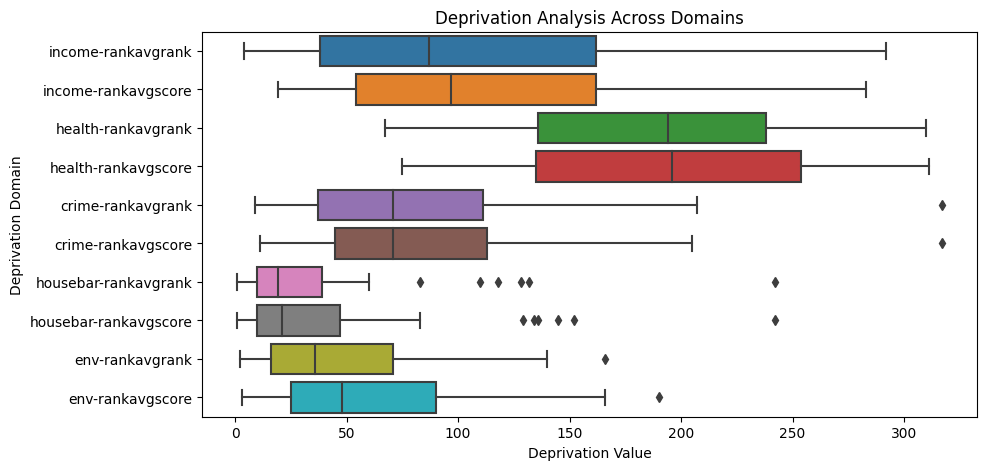

In [ ]:
# Domain-wise Analysis
plt.figure(figsize=(10, 5))
sns.boxplot(data=indices_rank, orient="h")
plt.title('Deprivation Analysis Across Domains')
plt.xlabel('Deprivation Value')
plt.ylabel('Deprivation Domain')
plt.show()

Observing the data, it's evident that boroughs in London face significant challenges in the Barriers to Housing & Services domain. This discrepancy may contribute to heightened tensions. The Barriers to Housing and Services domain assesses the ease of access, both physically and financially, to housing and local services. The indicators within this domain are categorized into 'geographical barriers,' focusing on the proximity of local services, and 'wider barriers,' encompassing issues like housing affordability. Lets visualize this below.

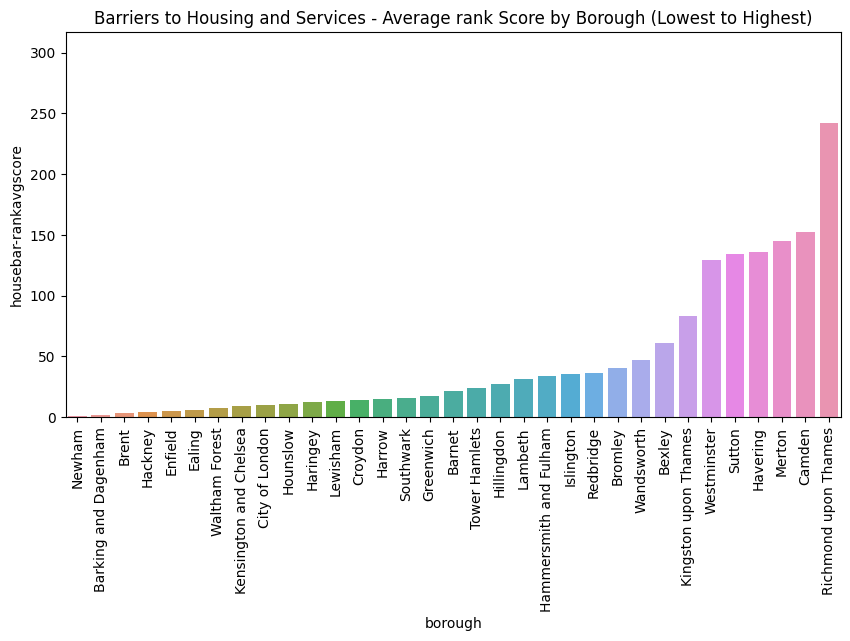

In [ ]:
# Set the maximum range for the y-axis
max_range = 317

# Sort the DataFrame by the 'housebar-rankavgscore' column
indices_sorted = indices_rank.sort_values(by='housebar-rankavgscore')

# Barriers to Housing and Services - Average rank Score by Borough
plt.figure(figsize=(10, 5))
sns.barplot(x='borough', y='housebar-rankavgscore', data=indices_sorted)
plt.title('Barriers to Housing and Services - Average rank Score by Borough (Lowest to Highest)')
plt.xticks(rotation=90)

# Set the maximum range for the y-axis
plt.ylim(0, max_range)

plt.show()

### Correlation of Feature Variables

<ipython-input-39-39551aa13ead>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = indices_rank.corr()


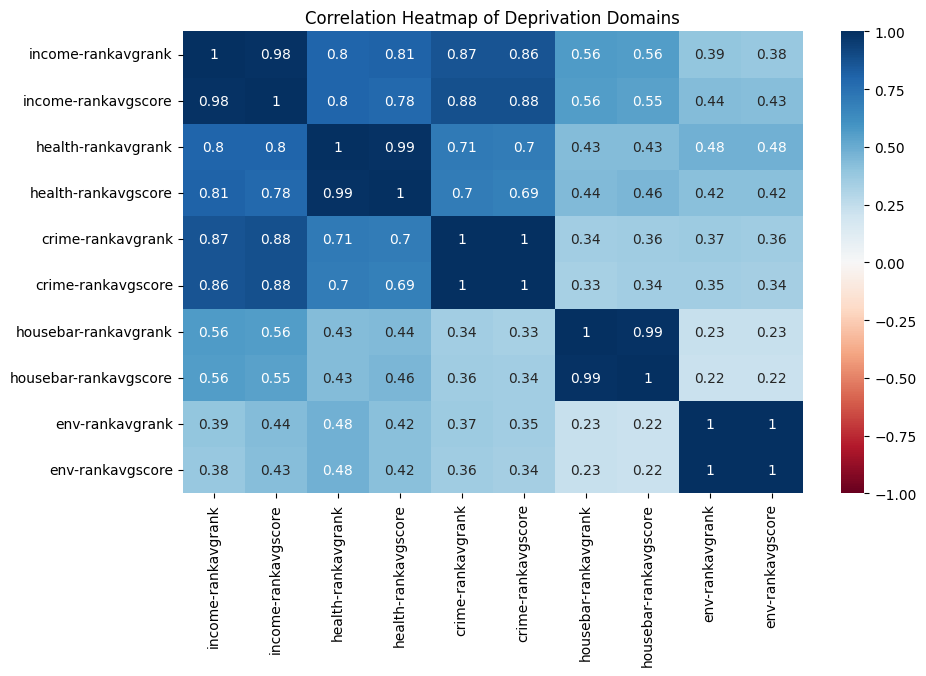

In [ ]:
correlation_matrix = indices_rank.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmax=1,vmin = -1)
plt.title('Correlation Heatmap of Deprivation Domains')
plt.show()

We notice a robust positive correlation among features measuring similar deprivation indices. Given this correlation, we'll exclude all features with the "-rankavgrank" suffix from our analysis .

<ipython-input-40-51eb9bbe3606>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = indices_rank_final.corr()


Text(0.5, 1.0, 'Correlation Heatmap of Deprivation Domains')

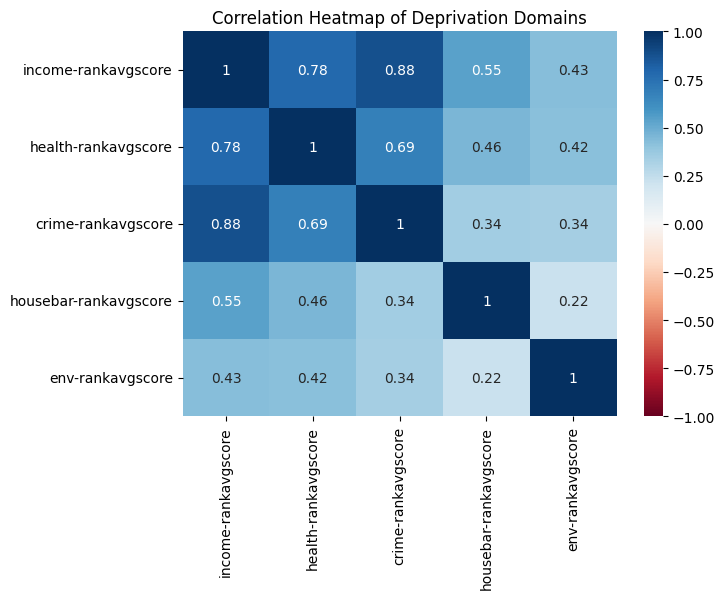

In [ ]:
indices_rank_final = indices_rank[['borough', 'income-rankavgscore','health-rankavgscore','crime-rankavgscore','housebar-rankavgscore','env-rankavgscore']]

correlation_matrix = indices_rank_final.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmax=1,vmin = -1)
plt.title('Correlation Heatmap of Deprivation Domains')
#plt.show()

### Income - Average rank Score by Borough vs Crime - Average rank Score by Borough

The correlation matrix indicates that the deprivation measures of income and crime are strongly correlated possitvely. Lst visuallze these two features on a bar plot side by side to gain better intuition of they correlate with one another.

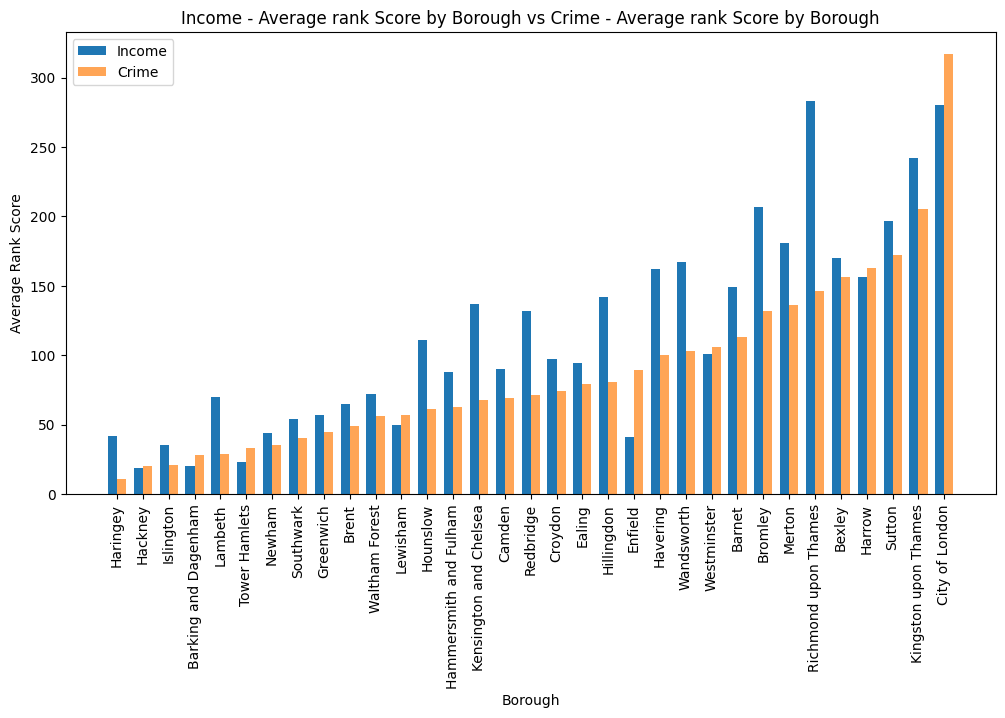

In [ ]:
import numpy as np
# Set the maximum range for the y-axis
max_range = 317

# Sort the DataFrame by the 'income-rankavgscore' column
indices_sorted_income = indices_rank_final.sort_values(by='crime-rankavgscore')

# Set up the plot
plt.figure(figsize=(12, 6))

# Barriers to Housing and Services and Crime - Average rank Score by Borough
bar_width = 0.35
bar_positions = np.arange(len(indices_sorted_income))

plt.bar(bar_positions - bar_width/2, indices_sorted_income['income-rankavgscore'], width=bar_width, label='Income')
plt.bar(bar_positions + bar_width/2, indices_sorted_income['crime-rankavgscore'], width=bar_width, label='Crime', alpha=0.7)

plt.title('Income - Average rank Score by Borough vs Crime - Average rank Score by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Rank Score')
plt.xticks(bar_positions, indices_sorted_income['borough'], rotation=90)

# Show the legend
plt.legend()
plt.show()

# Council Tax Charges data exploration

The council tax band determines how much council tax residents pay. It's calculated based on the value of property at a specific point in time. For instance, in England the council tax band is based on what the value of a property would have been on 1 April 1991. Properties in England are put into one of eight bands (A-H), depending on the price they would have sold for in April 1991. If your property is newly built, the Valuation Office Agency for England and Wales (VOA) will automatically assess it in order to place it in a council tax band.

The Council Tax Charges dataset contains data about the tax bands for each Borough. This dataset does not include the price value used to determine bands. To provide that context, lets import a table from a webpage that contains this information: https://www.which.co.uk/money/tax/council-tax/council-tax-bands-aCB0I1o9UTe1

In [ ]:
import requests
from lxml import html
response = requests.get("https://www.which.co.uk/money/tax/council-tax/council-tax-bands-aCB0I1o9UTe1")

# Parse HTML file
tree = html.fromstring(response.content)

# first table in the webpage
xpath_expression = "//table[1]"

# Extract the table
target_table = tree.xpath(xpath_expression)[0]

# Convert the table to a DataFrame
tax_bands = pd.read_html(html.tostring(target_table))[0]
tax_bands

,Council tax band,Ranges of value
0,A,"Up to £40,000"
1,B,"£40,000-£52,000"
2,C,"£52,000-£68,000"
3,D,"£68,000-£88,000"
4,E,"£88,000-£120,000"
5,F,"£120,000-£160,000"
6,G,"£160,000-£320,000"


In [ ]:
tax_rates.sort_values(by = ['borough'],ascending=[True], inplace = True)


In [ ]:
tax_rates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 1 to 32
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   code     33 non-null     object
 1   borough  33 non-null     object
 2   band_a   33 non-null     object
 3   band_b   33 non-null     object
 4   band_c   33 non-null     object
 5   band_d   33 non-null     object
 6   band_e   33 non-null     object
 7   band_f   33 non-null     object
 8   band_g   33 non-null     object
 9   band_h   33 non-null     object
dtypes: object(10)
memory usage: 2.8+ KB


Droping irrelevant columns and removing the commas(",") from the band values then casting them to type int.

In [ ]:
tax_band_rates = tax_rates.drop(columns=['code'])

# Convert the 'band' columns to integers
band_columns = ['band_a', 'band_b', 'band_c', 'band_d', 'band_e', 'band_f', 'band_g', 'band_h']
tax_band_rates[band_columns] = tax_band_rates[band_columns].replace({',': ''}, regex=True).astype(int)

tax_band_rates


,borough,band_a,band_b,band_c,band_d,band_e,band_f,band_g,band_h
1,Barking & Dagenham,1037,1210,1383,1556,1902,2248,2593,3112
2,Barnet,1030,1202,1374,1545,1889,2232,2576,3091
3,Bexley,1119,1306,1492,1679,2052,2425,2798,3358
4,Brent,1055,1231,1407,1583,1935,2286,2638,3166
5,Bromley,1025,1195,1366,1537,1878,2220,2561,3074
6,Camden,1042,1215,1389,1563,1910,2257,2604,3125
0,City of London,648,757,865,973,1189,1405,1621,1945
7,Croydon,1145,1335,1526,1717,2098,2480,2861,3434
8,Ealing,1008,1176,1344,1512,1848,2184,2520,3024
9,Enfield,1088,1269,1451,1632,1995,2357,2720,3264


In [ ]:
tax_band_rates.dtypes

borough    object
band_a      int64
band_b      int64
band_c      int64
band_d      int64
band_e      int64
band_f      int64
band_g      int64
band_h      int64
dtype: object

###What Boroughs pay the most and least tax across bands?

In [ ]:
calculate_tax = lambda band_column: pd.Series({
    'max_borough': tax_band_rates.loc[tax_band_rates[band_column].idxmax(), 'borough'],
    'min_borough': tax_band_rates.loc[tax_band_rates[band_column].idxmin(), 'borough'],
    'max_tax': tax_band_rates[band_column].max(),
    'min_tax': tax_band_rates[band_column].min()
})

df_max_min_tax = tax_band_rates.columns[1:].to_series().apply(calculate_tax).reset_index()
df_max_min_tax.columns = ['band', 'max_borough', 'min_borough', 'max_tax', 'min_tax']
df_max_min_tax

,band,max_borough,min_borough,max_tax,min_tax
0,band_a,Kingston-upon-Thames,Westminster,1248,504
1,band_b,Kingston-upon-Thames,Westminster,1456,588
2,band_c,Kingston-upon-Thames,Westminster,1664,672
3,band_d,Kingston-upon-Thames,Westminster,1872,755
4,band_e,Kingston-upon-Thames,Westminster,2288,923
5,band_f,Kingston-upon-Thames,Westminster,2704,1091
6,band_g,Kingston-upon-Thames,Westminster,3120,1259
7,band_h,Kingston-upon-Thames,Westminster,3743,1511


# Join Indices of Deprivation data with Council Tax Charges data

In [ ]:
data = indices_rank_final.merge(tax_band_rates, left_on=['borough'], right_on=['borough'], how = 'outer', indicator=True)

In [ ]:
data = data[data['_merge']!= 'both']
data

,borough,income-rankavgscore,health-rankavgscore,crime-rankavgscore,housebar-rankavgscore,env-rankavgscore,band_a,band_b,band_c,band_d,band_e,band_f,band_g,band_h,_merge
1,Barking and Dagenham,20.0,96.0,28.0,2.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
12,Hammersmith and Fulham,88.0,141.0,63.0,34.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
19,Kensington and Chelsea,137.0,307.0,68.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
20,Kingston upon Thames,242.0,287.0,205.0,83.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
26,Richmond upon Thames,283.0,311.0,146.0,242.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
33,Barking & Dagenham,NaN,NaN,NaN,NaN,NaN,1037.0,1210.0,1383.0,1556.0,1902.0,2248.0,2593.0,3112.0,right_only
34,Hammersmith & Fulham,NaN,NaN,NaN,NaN,NaN,722.0,842.0,962.0,1083.0,1323.0,1564.0,1804.0,2165.0,right_only
35,Kensington & Chelsea,NaN,NaN,NaN,NaN,NaN,805.0,939.0,1074.0,1208.0,1476.0,1745.0,2013.0,2416.0,right_only
36,Kingston-upon-Thames,NaN,NaN,NaN,NaN,NaN,1248.0,1456.0,1664.0,1872.0,2288.0,2704.0,3120.0,3743.0,right_only
37,Richmond-upon-Thames,NaN,NaN,NaN,NaN,NaN,1202.0,1403.0,1603.0,1804.0,2205.0,2605.0,3006.0,3607.0,right_only


The join does not work as expected because of the use of 'and' vs '&" in both data set, we'll instead look at doing approximate matching.

In [ ]:
import py_stringsimjoin as ssj
import py_stringmatching as sm

tok = sm.QgramTokenizer(qval=5,return_set=True)

# Convert columns to string for better comparison
indices_rank_final['borough'] = indices_rank_final['borough'].astype(str)
tax_band_rates['borough'] = tax_band_rates['borough'].astype(str)

# Compute Jaccard similarity
output_pairs = ssj.jaccard_join(indices_rank_final, tax_band_rates,'borough', 'borough', 'borough', 'borough',tok, 0.3)
output_pairs

<ipython-input-50-8095719a597a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indices_rank_final['borough'] = indices_rank_final['borough'].astype(str)
/usr/local/lib/python3.10/dist-packages/py_stringsimjoin/utils/generic_helper.py:76: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  projected_dataframe = dataframe[proj_attrs].dropna(0,
/usr/local/lib/python3.10/dist-packages/py_stringsimjoin/utils/generic_helper.py:76: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  projected_dataframe = dataframe[proj_attrs].dropna(0,
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,_id,l_borough,r_borough,_sim_score
0,0,Barking and Dagenham,Barking & Dagenham,0.586207
1,1,Barnet,Barnet,1.000000
2,2,Bexley,Bexley,1.000000
3,3,Brent,Brent,1.000000
4,4,Bromley,Bromley,1.000000
5,5,Camden,Camden,1.000000
6,6,City of London,City of London,1.000000
7,7,Croydon,Croydon,1.000000
8,8,Ealing,Ealing,1.000000
9,9,Enfield,Enfield,1.000000


In [ ]:
socio_econ_df = pd.merge(output_pairs, indices_rank_final, left_on='l_borough', right_on='borough', how='left')
socio_econ_df = pd.merge(socio_econ_df, tax_band_rates, left_on='r_borough', right_on='borough', how='left')

# Drop irrelevant columns from the merges
socio_econ_df = socio_econ_df.drop(['borough_x', 'borough_y','_id','r_borough','_sim_score' ], axis=1)
socio_econ_df = socio_econ_df.rename(columns={'l_borough': 'borough'})
socio_econ_df

,borough,income-rankavgscore,health-rankavgscore,crime-rankavgscore,housebar-rankavgscore,env-rankavgscore,band_a,band_b,band_c,band_d,band_e,band_f,band_g,band_h
0,Barking and Dagenham,20,96,28,2,52,1037,1210,1383,1556,1902,2248,2593,3112
1,Barnet,149,298,113,21,91,1030,1202,1374,1545,1889,2232,2576,3091
2,Bexley,170,230,156,61,144,1119,1306,1492,1679,2052,2425,2798,3358
3,Brent,65,207,49,3,54,1055,1231,1407,1583,1935,2286,2638,3166
4,Bromley,207,280,132,40,166,1025,1195,1366,1537,1878,2220,2561,3074
5,Camden,90,227,69,152,35,1042,1215,1389,1563,1910,2257,2604,3125
6,City of London,280,254,317,10,13,648,757,865,973,1189,1405,1621,1945
7,Croydon,97,165,74,14,77,1145,1335,1526,1717,2098,2480,2861,3434
8,Ealing,94,189,79,6,46,1008,1176,1344,1512,1848,2184,2520,3024
9,Enfield,41,222,89,5,65,1088,1269,1451,1632,1995,2357,2720,3264


<ipython-input-52-05e15cb47281>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = socio_econ_df.corr()


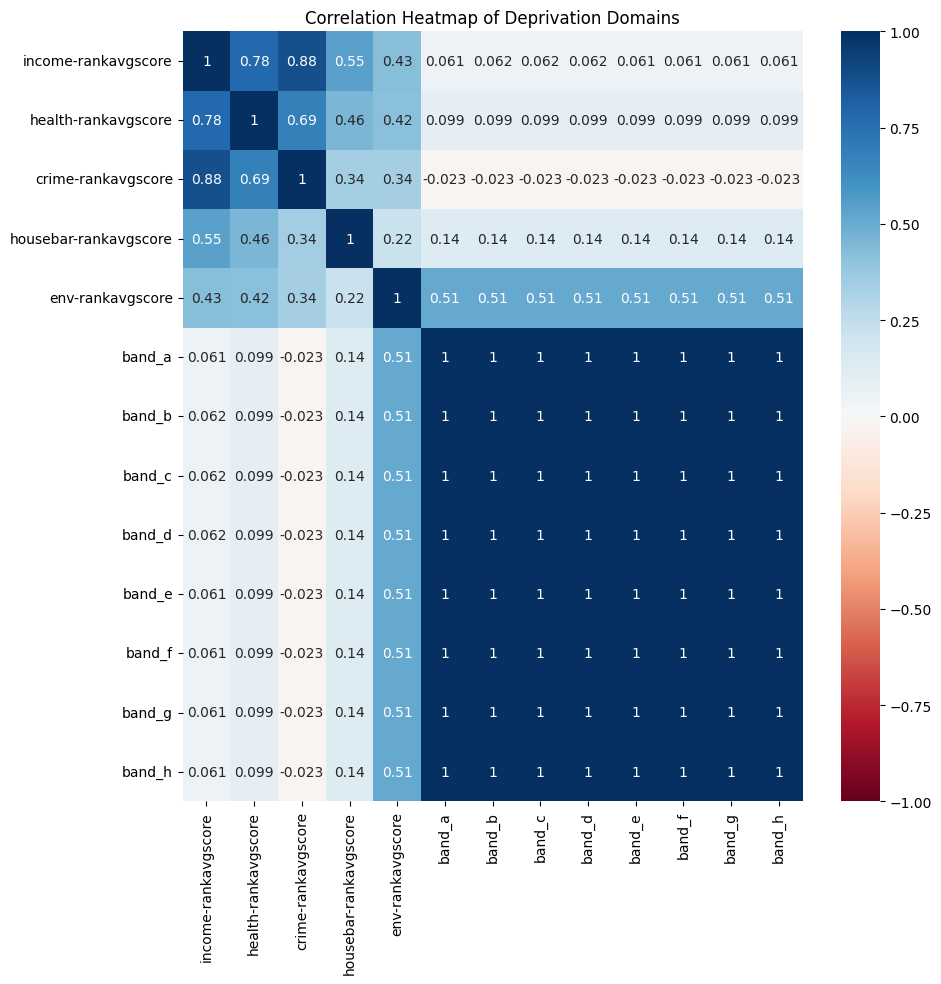

In [ ]:

correlation_matrix = socio_econ_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmax=1,vmin = -1)
plt.title('Correlation Heatmap of Deprivation Domains')
plt.show()

To avoid multicollinearity issues, we will take the average of the 'band' variables to consolidate the information from those highly correlated features into a single representative feature.

In [ ]:

band_columns = ['band_a', 'band_b', 'band_c', 'band_d', 'band_e', 'band_f', 'band_g', 'band_h']

# calculate the average tax band per borough
socio_econ_df['average_tax_band'] = socio_econ_df[band_columns].mean(axis=1)

# Drop band features
socio_econ_df.drop(columns=band_columns, inplace=True)

socio_econ_df

,borough,income-rankavgscore,health-rankavgscore,crime-rankavgscore,housebar-rankavgscore,env-rankavgscore,average_tax_band
0,Barking and Dagenham,20,96,28,2,52,1880.125
1,Barnet,149,298,113,21,91,1867.375
2,Bexley,170,230,156,61,144,2028.625
3,Brent,65,207,49,3,54,1912.625
4,Bromley,207,280,132,40,166,1857.000
5,Camden,90,227,69,152,35,1888.125
6,City of London,280,254,317,10,13,1175.375
7,Croydon,97,165,74,14,77,2074.500
8,Ealing,94,189,79,6,46,1827.000
9,Enfield,41,222,89,5,65,1972.000


In [ ]:
# Limit our airbnb data to include only the 13 burroughs
socio_econ_df = socio_econ_df.loc[socio_econ_df['borough'].isin(burroughs)].reset_index(drop=True)

socio_econ_df

,borough,income-rankavgscore,health-rankavgscore,crime-rankavgscore,housebar-rankavgscore,env-rankavgscore,average_tax_band
0,Camden,90,227,69,152,35,1888.125
1,City of London,280,254,317,10,13,1175.375
2,Greenwich,57,134,45,17,92,1800.125
3,Hackney,19,75,20,4,21,1758.000
4,Hammersmith and Fulham,88,141,63,34,25,1308.125
5,Islington,35,89,21,35,23,1800.125
6,Kensington and Chelsea,137,307,68,9,6,1459.500
7,Lambeth,70,103,29,31,3,1746.250
8,Lewisham,50,120,57,13,20,1914.500
9,Newham,44,135,35,1,40,1608.750


In [ ]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/CIS5450/Term_Project/data/db_model')

# Save the DataFrame to a table in the SQLite database
try:
    socio_econ_df.to_sql('taxband', conn, index=False, if_exists='replace')
    print("Table successfully created.")
except Exception as e:
    print("Error:", e)
finally:
    # Close the connection
    conn.close()

Table successfully created.


# Combing all dataframes

### Joining property_avg_by_district and socio_econ_df

In [ ]:
temp_combined_df = property_avg_by_district.merge(socio_econ_df, left_on=['district'], right_on=['borough'], how = 'outer', indicator=True)
temp_combined_df = temp_combined_df.drop(['borough','_merge'], axis=1)
temp_combined_df

,district,price,cost_fl_area,income-rankavgscore,health-rankavgscore,crime-rankavgscore,housebar-rankavgscore,env-rankavgscore,average_tax_band
0,Kensington and Chelsea,2.100748e+06,16135.826273,137,307,68,9,6,1459.500
1,Westminster,1.401428e+06,13431.389554,101,272,106,129,8,912.875
2,City of London,8.333125e+05,12990.393577,280,254,317,10,13,1175.375
3,Camden,1.138965e+06,10919.350311,90,227,69,152,35,1888.125
4,Hammersmith and Fulham,9.847065e+05,9601.691831,88,141,63,34,25,1308.125
5,Islington,7.621404e+05,8970.427173,35,89,21,35,23,1800.125
6,Wandsworth,7.755212e+05,8091.661552,167,196,103,47,39,930.875
7,Hackney,6.495731e+05,7872.211092,19,75,20,4,21,1758.000
8,Southwark,6.142248e+05,7551.588104,54,112,40,16,22,1675.875
9,Lambeth,6.223003e+05,7404.709092,70,103,29,31,3,1746.250


#Join airbnb data with the previosuly combined data

In [ ]:
# let's look at the number of rows of the dfs we want to merge
print('properties_avg_by_district', len(temp_combined_df.index))
print('merged airbnb df', len(merged_df.index))

properties_avg_by_district 14
merged airbnb df 66771


In [ ]:
main_df = merged_df.merge(temp_combined_df, left_on=['borough'], right_on=['district'],
                      how='left', indicator = True)


In [ ]:
main_df.head(10)

,borough,room_type,airbnb_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,num_listings,district,price,cost_fl_area,income-rankavgscore,health-rankavgscore,crime-rankavgscore,housebar-rankavgscore,env-rankavgscore,average_tax_band,_merge
0,Islington,Private room,65.0,1,21,2020-02-22,0.18,5019,Islington,7.621404e+05,8970.427173,35,89,21,35,23,1800.125,both
1,Kensington and Chelsea,Entire home/apt,100.0,10,89,2020-03-16,0.71,6079,Kensington and Chelsea,2.100748e+06,16135.826273,137,307,68,9,6,1459.500,both
2,Westminster,Entire home/apt,300.0,3,42,2019-11-02,0.38,9943,Westminster,1.401428e+06,13431.389554,101,272,106,129,8,912.875,both
3,Hammersmith and Fulham,Private room,150.0,3,0,NaT,0.00,4233,Hammersmith and Fulham,9.847065e+05,9601.691831,88,141,63,34,25,1308.125,both
4,Wandsworth,Entire home/apt,65.0,21,35,2020-03-30,0.70,4261,Wandsworth,7.755212e+05,8091.661552,167,196,103,47,39,930.875,both
5,Hackney,Entire home/apt,80.0,6,52,2019-03-30,0.44,6210,Hackney,6.495731e+05,7872.211092,19,75,20,4,21,1758.000,both
6,Southwark,Private room,70.0,2,55,2019-06-27,0.46,4957,Southwark,6.142248e+05,7551.588104,54,112,40,16,22,1675.875,both
7,Tower Hamlets,Entire home/apt,65.0,2,137,2017-04-21,1.18,8321,Tower Hamlets,5.212388e+05,7329.230404,23,98,33,24,36,1619.250,both
8,Hammersmith and Fulham,Private room,62.0,2,366,2020-03-15,3.18,4233,Hammersmith and Fulham,9.847065e+05,9601.691831,88,141,63,34,25,1308.125,both
9,Hammersmith and Fulham,Entire home/apt,296.0,5,35,2020-02-28,0.37,4233,Hammersmith and Fulham,9.847065e+05,9601.691831,88,141,63,34,25,1308.125,both


Let's look to see if there was any data that did not make it in the left join.

In [ ]:
main_df[main_df['_merge'] != 'both']

,borough,room_type,airbnb_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,num_listings,district,price,cost_fl_area,income-rankavgscore,health-rankavgscore,crime-rankavgscore,housebar-rankavgscore,env-rankavgscore,average_tax_band,_merge


In [ ]:
# since there was no data that didn't make the full join, let's take out the indicator column
main_df = main_df.drop(['_merge'], axis=1)

# we can also drop the district column since it will be redundant with borough
main_df = main_df.drop(['district'], axis=1)


# Prepare data for Concatenation


### One-hot encode: propertytype, oldnew, street and district

In [ ]:
# Let look at the unique values in propertytype, oldnew and street
print(main_df['borough'].unique())
# put description of values for propertytype
print(main_df['room_type'].unique())

['Islington' 'Kensington and Chelsea' 'Westminster'
 'Hammersmith and Fulham' 'Wandsworth' 'Hackney' 'Southwark'
 'Tower Hamlets' 'Camden' 'Newham' 'Lambeth' 'Lewisham' 'Greenwich'
 'City of London']
<StringArray>
['Private room', 'Entire home/apt', 'Hotel room', 'Shared room']
Length: 4, dtype: string


In [ ]:
# one-hot encode borough and room_type
categorical_cols = ['room_type', 'borough']
main_df = pd.get_dummies(main_df, columns=categorical_cols)
main_df.head(5)

,airbnb_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,num_listings,price,cost_fl_area,income-rankavgscore,health-rankavgscore,...,borough_Hammersmith and Fulham,borough_Islington,borough_Kensington and Chelsea,borough_Lambeth,borough_Lewisham,borough_Newham,borough_Southwark,borough_Tower Hamlets,borough_Wandsworth,borough_Westminster
0,65.0,1,21,2020-02-22,0.18,5019,7.621404e+05,8970.427173,35,89,...,0,1,0,0,0,0,0,0,0,0
1,100.0,10,89,2020-03-16,0.71,6079,2.100748e+06,16135.826273,137,307,...,0,0,1,0,0,0,0,0,0,0
2,300.0,3,42,2019-11-02,0.38,9943,1.401428e+06,13431.389554,101,272,...,0,0,0,0,0,0,0,0,0,1
3,150.0,3,0,NaT,0.00,4233,9.847065e+05,9601.691831,88,141,...,1,0,0,0,0,0,0,0,0,0
4,65.0,21,35,2020-03-30,0.70,4261,7.755212e+05,8091.661552,167,196,...,0,0,0,0,0,0,0,0,1,0


<ipython-input-63-f774688ce7a6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = main_df.corr()


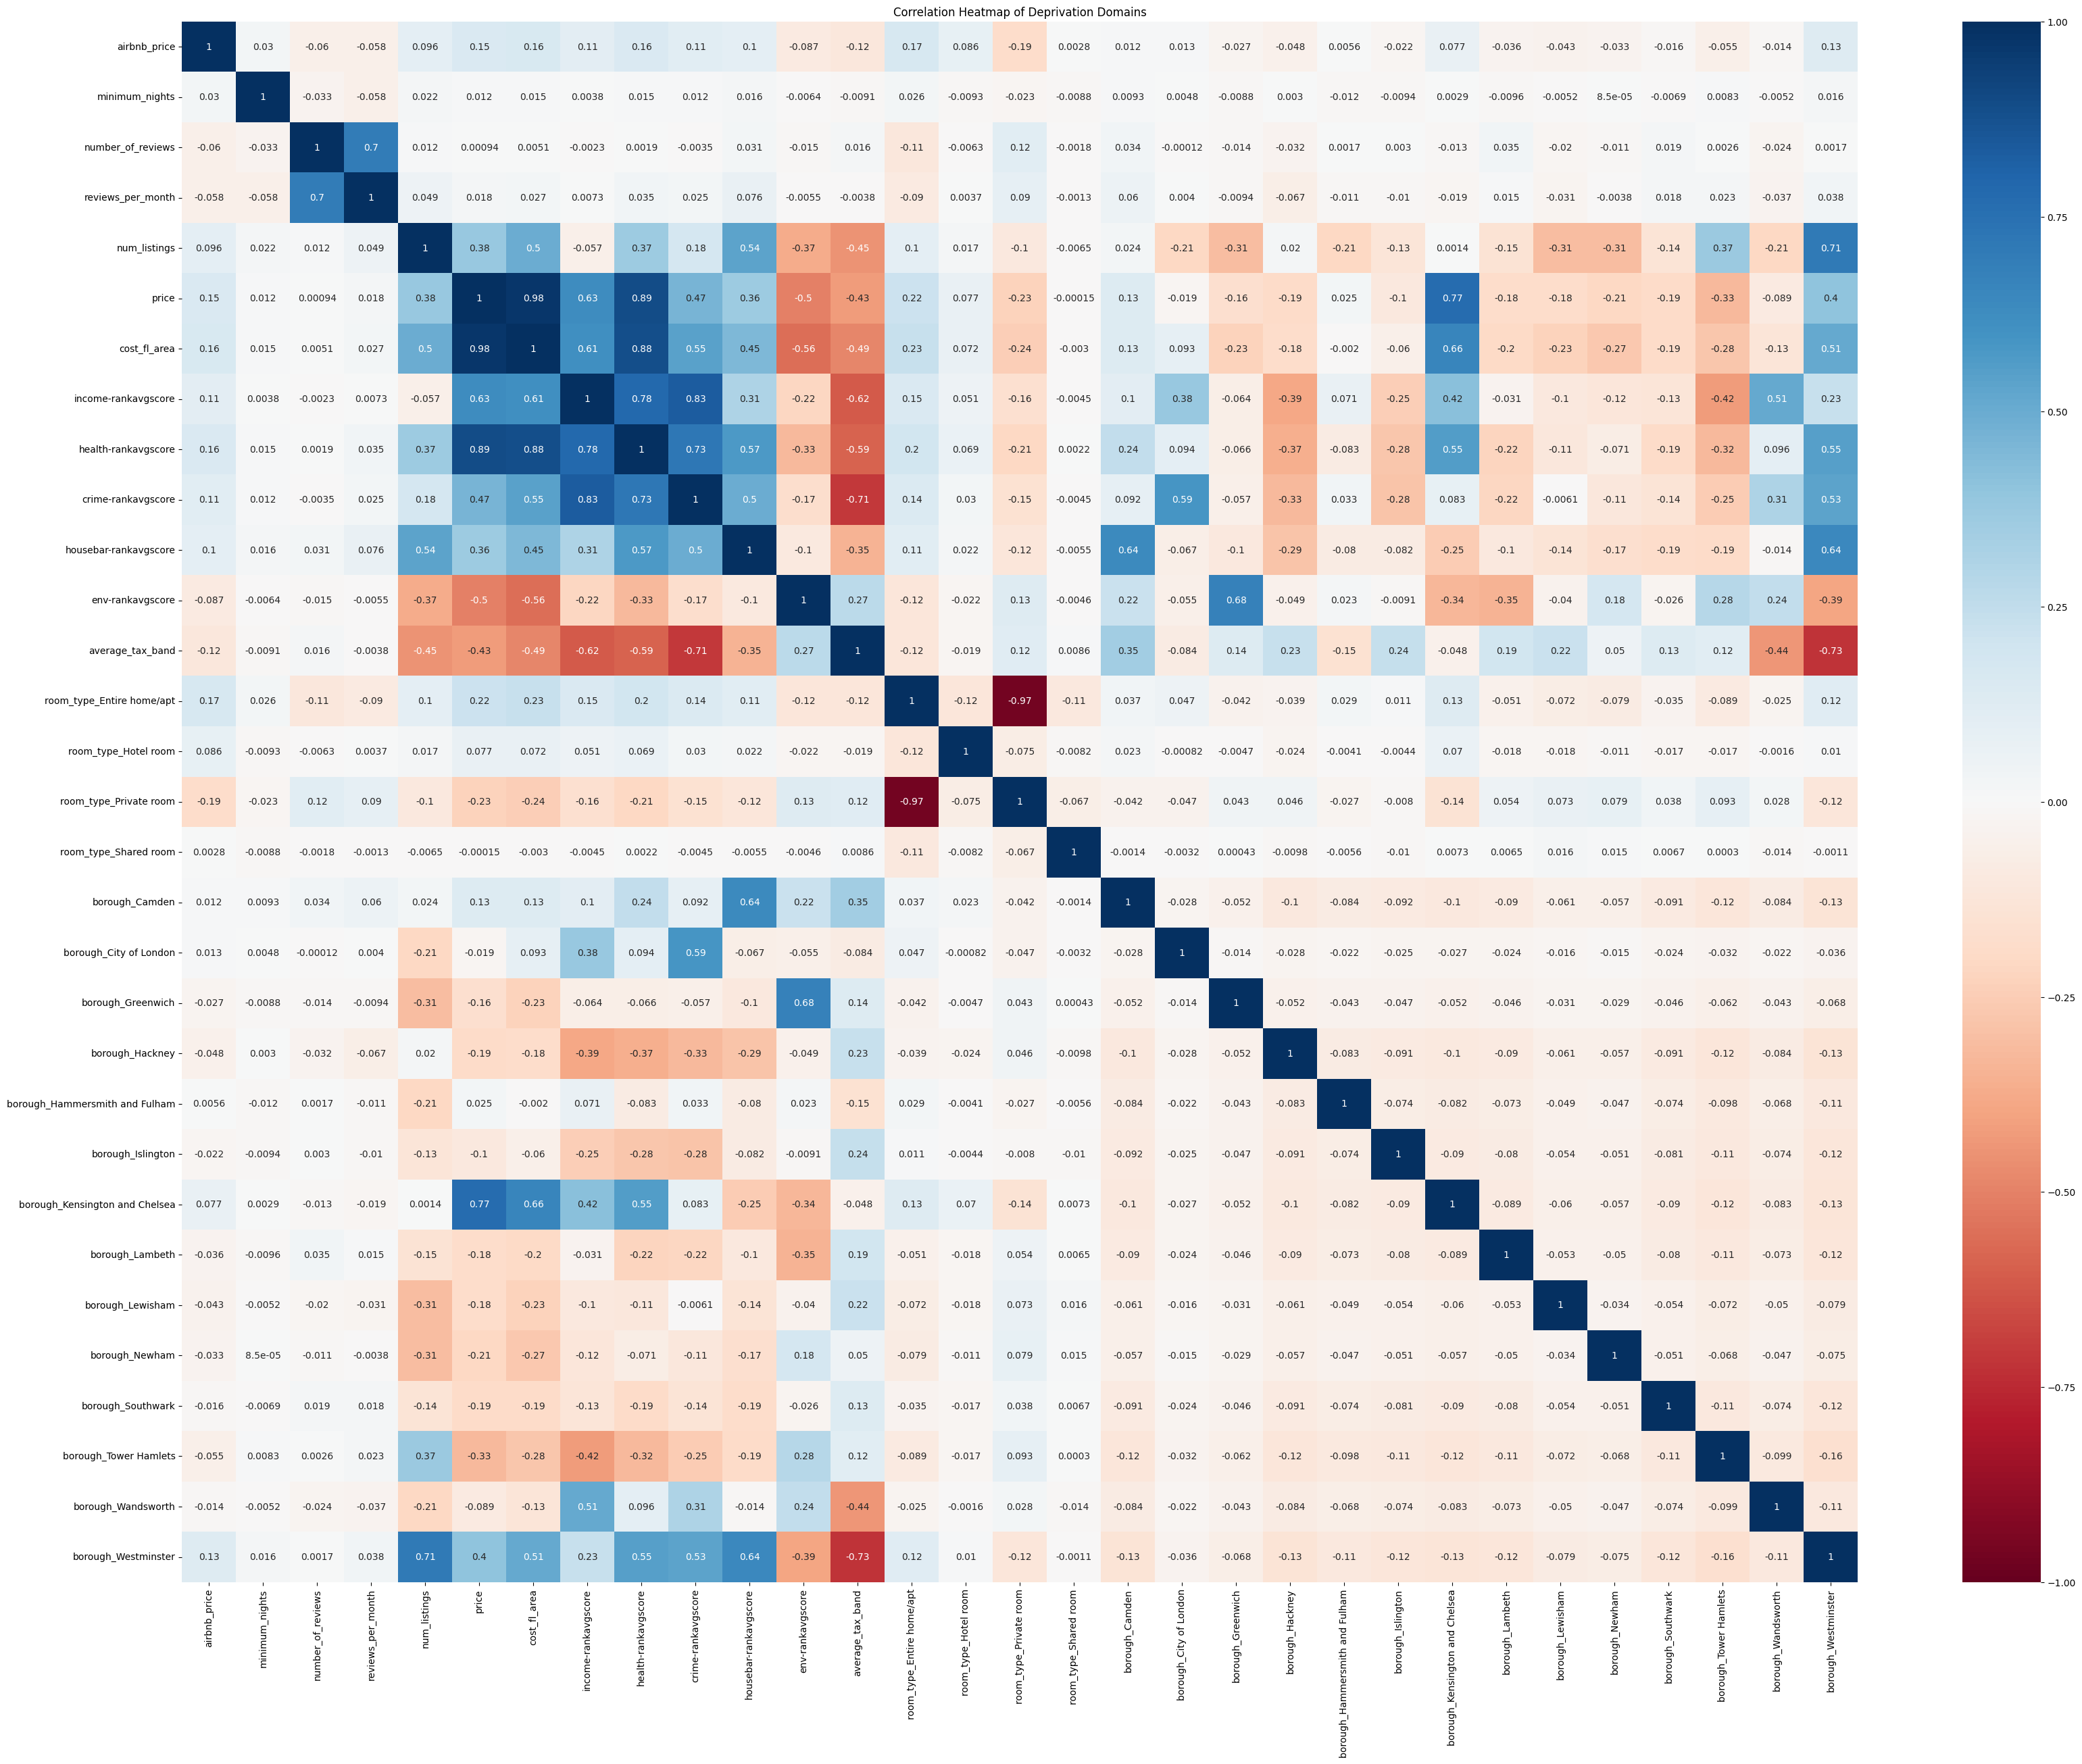

In [ ]:
correlation_matrix = main_df.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmax=1,vmin = -1)
plt.title('Correlation Heatmap of Deprivation Domains')
plt.show()

<ipython-input-64-95a3af8c415c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(main_df.corr(), cmap='coolwarm')


<Axes: >

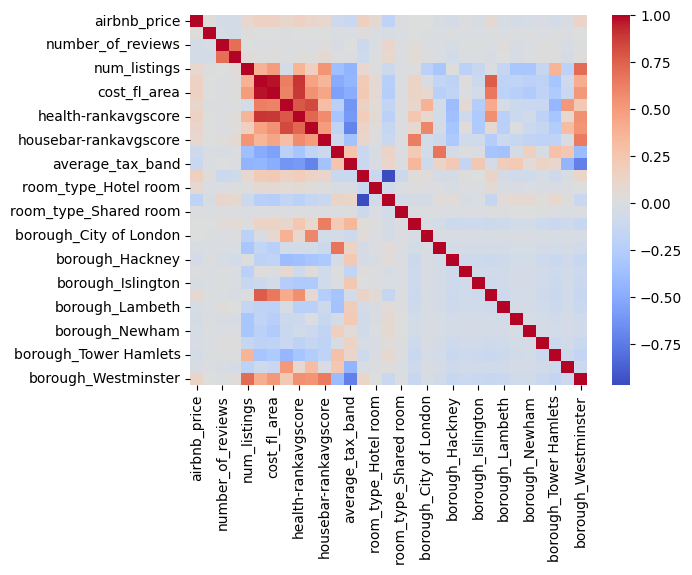

In [ ]:
%matplotlib inline

sns.heatmap(main_df.corr(), cmap='coolwarm')

In [ ]:
#!pip install db-sqlite3
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/CIS5450/Term_Project/data/db_model')

# Save the DataFrame to a table in the SQLite database
try:
    main_df.to_sql('model', conn, index=False, if_exists='replace')
    print("Table successfully created.")
except Exception as e:
    print("Error:", e)
finally:
    # Close the connection
    conn.close()

Table successfully created.


In [ ]:
main_df.info()
filename='main.csv'
main_df.to_csv(filename, sep=',', index=False, encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66771 entries, 0 to 66770
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   airbnb_price                    66771 non-null  float64       
 1   minimum_nights                  66771 non-null  int32         
 2   number_of_reviews               66771 non-null  int32         
 3   last_review                     50686 non-null  datetime64[ns]
 4   reviews_per_month               66771 non-null  float64       
 5   num_listings                    66771 non-null  int64         
 6   price                           66771 non-null  float64       
 7   cost_fl_area                    66771 non-null  float64       
 8   room_type_Entire home/apt       66771 non-null  uint8         
 9   room_type_Hotel room            66771 non-null  uint8         
 10  room_type_Private room          66771 non-null  uint8         
 11  ro